In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
#Path to datasets
EFN_path = '/content/drive/My Drive/Cancer/NEW EFN/EFN_comb_pca.csv'
SWN_path = '/content/drive/My Drive/Cancer/NEW SWN/SWN_comb_pca.csv'

#Load datasets
EFN_df = pd.read_csv(EFN_path)
SWN_df = pd.read_csv(SWN_path)

#Cheking the shape of datasets
print(f'Shape of EfficientNet features: {EFN_df.shape}')
print(f'Shape of Swin Transformer features: {SWN_df.shape}')

#Viewing the first rows of datasets
print(EFN_df.head())
print(SWN_df.head())

Shape of EfficientNet features: (1000, 401)
Shape of Swin Transformer features: (1000, 401)
                       filename       PC1       PC2        PC3       PC4  \
0          HSIL_1 (1)_aug_0.jpg  6.883228 -8.065179   4.842025  7.476281   
1         HSIL_1 (10)_aug_0.jpg -5.761120 -7.481843   4.331707 -8.199776   
2         HSIL_1 (11)_aug_0.jpg -3.733144 -9.549364   1.457778 -0.491422   
3         HSIL_1 (12)_aug_0.jpg -1.572749 -1.624565  -5.295497  4.417744   
4  HSIL_1 (12)_aug_extra_57.jpg  0.008793  2.433184 -10.258959  0.912830   

        PC5        PC6       PC7       PC8        PC9  ...     PC391  \
0 -0.610270  11.128073 -5.690531 -7.088023   9.056043  ... -0.634501   
1 -2.954523   8.397054 -6.153464 -5.234269   5.218157  ...  0.230171   
2 -1.706776  15.873063 -1.344966 -2.662883  11.804904  ...  0.451170   
3 -3.854264  20.220553 -7.053946 -2.974186  12.729933  ...  0.470513   
4 -4.008668  18.544699 -5.164958 -1.099340  14.303882  ...  0.558876   

      PC392     PC

In [4]:
#Removing the first columns with names
EFN_features = EFN_df.drop(columns=['filename']).astype(float).values
SWN_features = SWN_df.drop(columns=['name']).astype(float).values

#Data scaling
scaler = StandardScaler(with_mean=True, with_std=True)

EFN_scaled = scaler.fit_transform(EFN_features)
SWN_scaled = scaler.transform(SWN_features)

#Cheking the shape of datasets
print(f'Shape of scaled EfficientNet features: {EFN_scaled.shape}')
print(f'Shape of scaled Swin Transformer features: {SWN_scaled.shape}')

Shape of scaled EfficientNet features: (1000, 400)
Shape of scaled Swin Transformer features: (1000, 400)


In [5]:
#Saving the column with image names
image_names = EFN_df['filename']

#Applying CCA with the number of components not exceeding the number of samples
n_components = min(EFN_scaled.shape[0], EFN_scaled.shape[1], SWN_scaled.shape[1]) - 1
cca = CCA(n_components=n_components)
EFN_c, SWN_c = cca.fit_transform(EFN_scaled, SWN_scaled)


/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


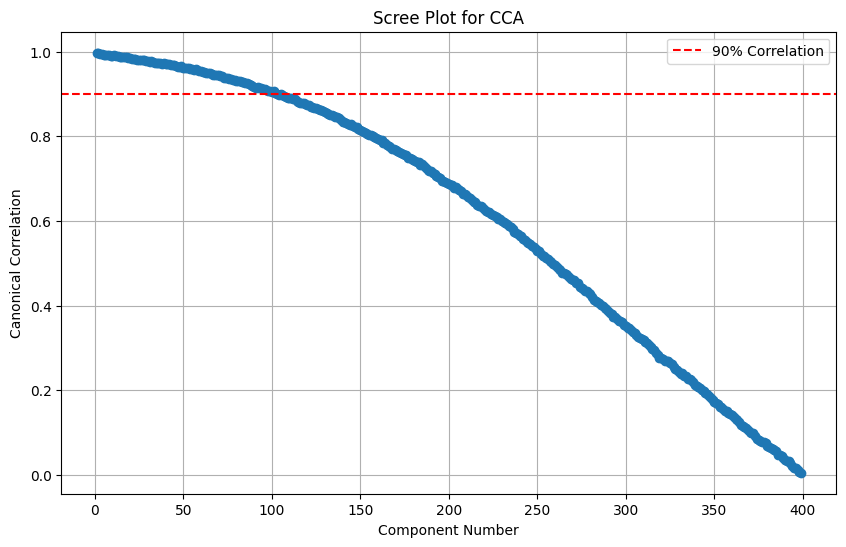

In [6]:
#Calculating correlation coefficients after CCA
correlations = np.corrcoef(EFN_c.T, SWN_c.T)[0:n_components, n_components:]

#Since the diagonal elements of the correlation matrix contain the correlations for each component, we select them for plotting
cca_correlations = np.diag(correlations)

#Plotting the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cca_correlations) + 1), cca_correlations, marker='o', linestyle='-')
plt.title('Scree Plot for CCA')
plt.xlabel('Component Number')
plt.ylabel('Canonical Correlation')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Correlation') # Adding a line at the 90% correlation level
plt.grid(True)
plt.legend()
plt.show()

In [7]:
#Applying CCA with 100 components
n_components = 100
cca = CCA(n_components=n_components)
EFN_c, SWN_c = cca.fit_transform(EFN_scaled, SWN_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


In [8]:
#Combining the transformed features
combined_features = np.hstack((EFN_c, SWN_c))

#Transform the combined features into a DataFrame and add a column with names
combined_df = pd.DataFrame(combined_features)
combined_df.insert(0, 'image_name', image_names.reset_index(drop=True))

#Displaying the first few rows of the combined DataFrame
print(combined_df.head())

#Save the combined DataFrame to a CSV file
combined_df.to_csv('/content/drive/My Drive/Cancer/AugImages/CCA_DON.csv', index=False)

                     image_name         0         1         2         3  \
0          HSIL_1 (1)_aug_0.jpg -0.753503  0.109218 -0.944134 -1.090103   
1         HSIL_1 (10)_aug_0.jpg -0.827939  0.417710 -1.295207 -1.218752   
2         HSIL_1 (11)_aug_0.jpg -0.827151 -0.625852 -0.561354 -1.917607   
3         HSIL_1 (12)_aug_0.jpg -1.270457  0.303015 -1.082936 -2.246055   
4  HSIL_1 (12)_aug_extra_57.jpg -1.853350  0.335712 -1.352681 -1.961002   

          4         5         6         7         8  ...       190       191  \
0  1.567614 -1.140856 -0.482961 -0.811448 -0.011368  ... -0.643385  0.439093   
1  1.157044 -1.363222  0.128874 -1.376113  0.040710  ... -0.770274 -0.311719   
2  0.631790 -1.805804 -0.986008  0.097057  0.518088  ... -0.328444 -2.653341   
3  0.896465 -1.036447  0.246125 -0.616684  1.558825  ...  0.457548  0.331741   
4 -0.343671 -2.104315 -1.775681  1.309410  2.558172  ... -0.046938 -0.041840   

        192       193       194       195       196       197       